In [4]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from glob import glob
import cv2
from concurrent.futures import ThreadPoolExecutor
from utils.matrix import project_points, select_points_within_bounds
from utils.colmap_data import COLMAP_Data
from scipy.spatial import KDTree

In [10]:
colmap_data = COLMAP_Data("data/sparse/0")

In [5]:
def project_to_image(data, idx):
    """
    Given frame index, project points to image and select points within image bounds
    """
    E = data.E
    points = data.points
    colors = data.colors
    K = data.K
    distortion = data.distortion
    width, height = data.width, data.height
    frame_names = data.frame_names

    e = E[frame_names[idx]]

    projected_points = project_points(points, e, K, distortion)
    bound_points, bound_colors = select_points_within_bounds(projected_points, width, height, colors)

    # invert y axis
    bound_points[:, 1] = height - bound_points[:, 1]
    return bound_points, bound_colors

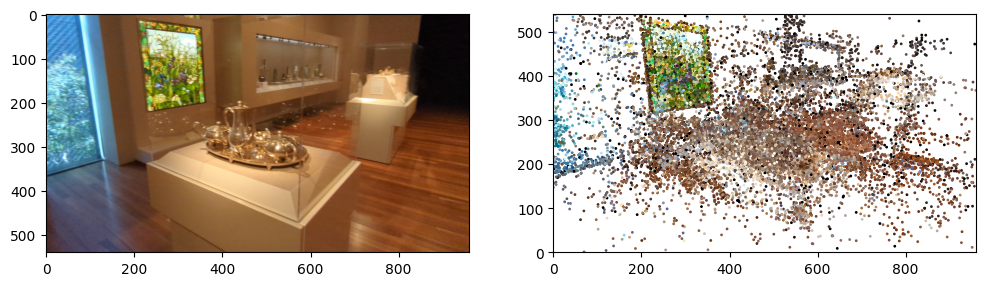

In [11]:
i = 0
projected_points, projected_colors = project_to_image(colmap_data, i)

img = plt.imread(f"data/images/{colmap_data.frame_names[i]}")

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(img)
axs[0].set_aspect('equal')

axs[1].scatter(projected_points[:, 0], projected_points[:, 1], c=projected_colors, s=1)
axs[1].set_xlim(0, colmap_data.width)
axs[1].set_ylim(0, colmap_data.height)
axs[1].set_aspect('equal')
plt.show()

In [22]:
from utils.matrix import quaternion_to_rotation_vectorized

class GaussianSplatting:
    def __init__(self, colmap_data: COLMAP_Data, images_path='data/images'):
        """
        M ← SfM Points ⊲ Positions
        """
        self.points = colmap_data.points
        self.colors = colmap_data.colors

        # self.images, self.height, self.width = self.get_images(images_path)
        self.sigmas = None
        self.alphas = None

    # def get_images(self, images_path):
    #     images_data = sorted(glob(images_path + '/*.png'))
    #     with ThreadPoolExecutor() as executor: # faster loading
    #         images = list(executor.map(cv2.imread, images_data))
    #     height, width, _ = images[0].shape
    #     return images, height, width
    
    def init_attributes(self):
        """
        𝑆,𝐶, 𝐴 ← InitAttributes() ⊲ Covariances, Colors, Opacities

        https://medium.com/@yianyao1994/gaussian-splatting-part-2-representation-and-initialization-c0a036adf16e
        
        Center: Set to the point cloud locations from SfM.
        Scaling factor: Initialized as isotropic, using the mean distance to the 3-nearest neighbors.
        Rotation: No initial rotation is applied.
        Opacity: Set to 0.1.
        Spherical Harmonics (SH): Inherited from the color information in the point cloud.

        """
        # 3D covariance matrix Σ
        pass

    def init_gaussian_covariance(self):
        """
        Explanation
        Sec 4: 
            Directly optimizing covariance matrix Σ can lead to non positive non semi-definite covariance matrices.
            Instead, we factorize Σ = 𝑅𝑆𝑆^𝑇𝑅^𝑇 [7dof], allowing anisotropic covariance and valid covariance matrices.
            For independent optimization, we store S: 3D vector for scaling and quaternion q (normalize to get valid unit quaternion)

            Convert these splats to pixel space
                W viewing transformation or extrinsics
                J Jacobian projective transformation or intrinsics
                Σ' = JW Σ W^TJ^T

        Initialization
        Sec 5.1
            "We estimate the initial covariance matrix as an isotropic Gaussian 
            with axes equal to the mean of the distance to the closest three points."

        Gradient Computation
        Appendix A
            dΣ' / ds = dΣ'/dΣ * dΣ / ds
            dΣ' / dq = dΣ'/dΣ * dΣ / dq

        Simplify Σ' = JW Σ W^TJ^T using U=JW and Σ' being (symmetric) upper left 2x2
        Σ' = U Σ U^T
        """
        points = self.points

        # non gradient implementation for now
        # Have to revist complexity of KDTree
        print(points.shape)
        kdtree = KDTree(points)
        distances, _ = kdtree.query(points, k=4)  # k=4 includes the point itself
        
        nearest_distances = distances[:, 1:4]
        mean_distances = nearest_distances.mean(axis=1)

        unit_q = np.array([1, 0, 0, 0])
        # ensure q is normalized
        q = np.repeat(unit_q[np.newaxis, :], len(points), axis=0) # (N, 4)
        r = quaternion_to_rotation_vectorized(q) # (N, 3, 3)

        # when initalizing, we sqrt since we will do (S @ ST) first
        s = np.sqrt(mean_distances[:, None, None]) * np.eye(3) # (N, 3, 3)

        # we do (S @ ST) first because it's a symmetric matrix
        # then we apply Rotation
        sigma = np.einsum('nij,nkj,nml,nlk->nim', s, s, r, r)
        return sigma

In [23]:
model = GaussianSplatting(colmap_data)
sigmas = model.init_gaussian_covariance()

(56042, 3)


In [25]:
# Visualize covariance

def create_ellipsoids_as_one_mesh(points, sigmas, colors, sphere_resolution=5):
    base_sphere = o3d.geometry.TriangleMesh.create_sphere(radius=1.0, resolution=sphere_resolution)
    base_sphere.compute_vertex_normals()
    
    all_vertices = []
    all_triangles = []
    all_colors = []

    base_vertices = np.asarray(base_sphere.vertices)
    base_triangles = np.asarray(base_sphere.triangles)

    vertex_count = 0
    
    for center, sigma, color in zip(points, sigmas, colors):
        scales = np.diagonal(sigma)
        transformed_vertices = base_vertices * scales + center

        all_vertices.append(transformed_vertices)
        all_colors.append(np.tile(color, (len(base_vertices), 1)))
        
        shifted_triangles = base_triangles + vertex_count
        all_triangles.append(shifted_triangles)

        vertex_count += len(base_vertices)
    
    all_vertices = np.vstack(all_vertices)
    all_triangles = np.vstack(all_triangles)
    all_colors = np.vstack(all_colors)

    big_mesh = o3d.geometry.TriangleMesh()
    big_mesh.vertices = o3d.utility.Vector3dVector(all_vertices)
    big_mesh.triangles = o3d.utility.Vector3iVector(all_triangles)
    big_mesh.vertex_colors = o3d.utility.Vector3dVector(all_colors)
    big_mesh.compute_vertex_normals()

    return big_mesh

viz_sigmas = sigmas / 4
big_mesh = create_ellipsoids_as_one_mesh(model.points, viz_sigmas, model.colors, sphere_resolution=10)
o3d.visualization.draw_geometries([big_mesh])

